In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

#### Contents:
- [Model Feature Selection](#Model-Feature-Selection)
- [Reduced Features Modeling](#Reduced-Features-Modeling)
- [Principal Component Analysis Modeling](#Principal-Component-Analysis-Modeling)
- [Model Selection](#Model-Selection)
- [Explore Residuals](#Explore-Residuals)

In [92]:
df = pd.read_csv('Data/final_data.csv')
df.head(3)

,is_open,review_count,stars,3d,abatement,acai,accessories,accountants,acne,active,...,stars_log,total_log,mean_review_count_log,state_NC,state_NV,state_OH,state_PA,state_WI,price_per_sqft_log,price_log
0,37,456,158.0,0,0,0,0,0,0,1,...,5.062595,3.688879,2.433613,0,0,0,1,0,4.174387,11.274668
1,158,3056,622.5,0,0,0,1,0,0,10,...,6.433744,5.192957,2.831905,0,0,0,1,0,4.828314,12.056412
2,23,160,96.0,0,0,0,0,0,0,1,...,4.564348,3.295837,1.779337,0,0,0,1,0,4.736198,11.936230


In [93]:
df.shape

(348, 1378)

In [94]:
df = df.fillna(0)

### Model Feature Selection

##### Lasso and Ridge will be ran to determine the first modeling pass and select most important features utilizing Lasso

In [95]:
# Set up the features and the target
X = df.drop(columns = ['price','price_per_sqft','price_log','price_per_sqft_log'])
y = df['price_per_sqft_log']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [96]:
# Scale the features
ss = StandardScaler()
ss.fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

/Users/dmitriy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/dmitriy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """
/Users/dmitriy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


The r squared is better than expected for training and testing, but performed poorly on cross validation, want to explore this further

In [97]:
# Run Lasso regression and check r squared for training, testing, and cross validation
la = LassoCV(max_iter=10000)
la.fit(X_train_ss, y_train)

print('Training r^2:', la.score(X_train_ss, y_train))
print('Testing r^2:', la.score(X_test_ss, y_test))
print('Cross Val r^2:', cross_val_score(la, X_train_ss, y_train).mean())
print(" ")
print("Alpha score:", la.alpha_)
print("Alpha rand:", min(la.alphas_), max(la.alphas_))

Training r^2: 0.654831677683541
Testing r^2: 0.6111339544361767
Cross Val r^2: 0.48588289854289196
 
Alpha score: 0.019934444426136018
Alpha rand: 0.00019934444426136018 0.19934444426136014


In [98]:
# Run Ridge regression and check r squared for training, testing, and cross validation
ridge_alphas = np.logspace(0,5,1000)
lr = RidgeCV(ridge_alphas)
lr.fit(X_train_ss, y_train)

print('Training r^2:', lr.score(X_train_ss, y_train))
print('Testing r^2:', lr.score(X_test_ss, y_test))
print('Cross Val r^2:', cross_val_score(lr, X_train_ss, y_train).mean())
print(" ")
print("Alpha score:", lr.alpha_)
print("Alpha rand:", min(ridge_alphas), max(ridge_alphas))

Training r^2: 0.8279969014941069
Testing r^2: 0.4327359807491329
Cross Val r^2: 0.33049099779272473
 
Alpha score: 230.33628731421314
Alpha rand: 1.0 100000.0


In [99]:
# Select Lasso's coeffiecients for the features 
coefs = pd.DataFrame({
    'variable': X_train.columns,
    'coefs': la.coef_
})

In [100]:
coefs.sort_values(by= 'coefs').head(10)

,variable,coefs
1371,state_OH,-0.092655
1372,state_PA,-0.050686
1362,percent_is_open,-0.035285
228,chicken,-0.026105
1113,soul,-0.020121
581,himalayan,-0.011425
992,registration,-0.010883
396,dumpster,-0.010265
439,excavation,-0.006211
245,civic,-0.004924


In [101]:
coefs.sort_values(by= 'coefs', ascending = False).head(10)

,variable,coefs
1368,mean_review_count_log,0.065833
1360,stars_mean,0.051183
1373,state_WI,0.049690
1365,review_count_log,0.017967
1246,train,0.016677
580,hiking,0.016436
1192,tapas,0.015619
1093,ski,0.015526
1346,wine,0.013842
531,gluten,0.012068


In [102]:
# Create a list of features that the model though were most impactful
new_features = list(coefs[np.abs(coefs['coefs'])>.00001]['variable'])

In [103]:
len(new_features)

44

### Reduced Features Modeling

- Lasso 
- Ridge
- Linear Regression 

In [104]:
# Setting up the filtered features and the target variable
X = df[new_features]
y = df['price_per_sqft_log']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [105]:
# Scale the data
ss = StandardScaler()
ss.fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

/Users/dmitriy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/dmitriy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """
/Users/dmitriy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [106]:
# Run Lasso regression and check r squared for training, testing, and cross validation
# Check the alpha to ensure it is in ~middle of the range

la2 = LassoCV(max_iter=10000)
la2.fit(X_train_ss, y_train)

print('Training r^2:', la2.score(X_train_ss, y_train))
print('Testing r^2:', la2.score(X_test_ss, y_test))
print('Cross Val r^2:', cross_val_score(la2, X_train_ss, y_train).mean())
print(" ")
print("Alpha score:", la2.alpha_)
print("Alpha rand:", min(la2.alphas_), max(la2.alphas_))

Training r^2: 0.7405596241235199
Testing r^2: 0.5772735193727503
Cross Val r^2: 0.5887290660036111
 
Alpha score: 0.004294745859818018
Alpha rand: 0.00019934444426136018 0.19934444426136014


In [107]:
# Run Ridge regression and check r squared for training, testing, and cross validation
# Check the alpha to ensure it is in ~middle of the range

ridge_alphas = np.logspace(0,5,1000)
lr2 = RidgeCV(ridge_alphas)
lr2.fit(X_train_ss, y_train)

print('Training r^2:', lr2.score(X_train_ss, y_train))
print('Testing r^2:', lr2.score(X_test_ss, y_test))
print('Cross Val r^2:', cross_val_score(lr2, X_train_ss, y_train).mean())
print(" ")
print("Alpha score:", lr2.alpha_)
print("Alpha rand:", min(ridge_alphas), max(ridge_alphas))

Training r^2: 0.7309455498424318
Testing r^2: 0.5772081528948931
Cross Val r^2: 0.6100638132582826
 
Alpha score: 58.44761131633635
Alpha rand: 1.0 100000.0


In [108]:
# Run Linear regression and check r squared for training, testing, and cross validation

lrr = LinearRegression()
lrr.fit(X_train_ss, y_train)

print('Training r^2:', lrr.score(X_train_ss, y_train))
print('Testing r^2:', lrr.score(X_test_ss, y_test))
print('Cross Val r^2:', cross_val_score(lrr, X_train_ss, y_train).mean())

Training r^2: 0.744912917931919
Testing r^2: 0.5485667583380676
Cross Val r^2: 0.5535659519374274


### Principal Component Analysis Modeling

PCA Tranformation

    -Lasso 
    -Ridge
    -Linear

In [109]:
# Initiating PCA to explore to see if it can improve the model perfromance

pca = PCA()
pca.fit(X_train_ss)
Z_train = pca.transform(X_train_ss)
Z_test = pca.transform(X_test_ss)
cum_var_exp = np.cumsum(var_exp)
print('Cumulative explained variance: ', cum_var_exp)

Cumulative explained variance:  [0.18097483 0.25172546 0.30931195 0.36389126 0.40862688 0.44754751
 0.48612759 0.52145541 0.5527752  0.58223842 0.60952202 0.63521124
 0.66054694 0.68452707 0.70776895 0.72969366 0.7507476  0.77057643
 0.78911146 0.8066426  0.82328079 0.83910277 0.85423885 0.86879437
 0.88236942 0.89544737 0.90782395 0.91938819 0.93023234 0.94006847
 0.9491049  0.95796245 0.96580943 0.97349243 0.98061473 0.98672944
 0.99128534 0.99538787 0.99823028 0.99969487 1.         1.
 1.         1.        ]


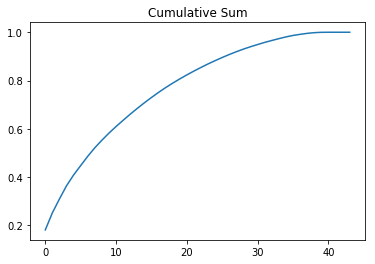

In [110]:
# Plotting the cumulative sum to get a better understanding of the model
plt.plot(cum_var_exp)
plt.title('Cumulative Sum')
plt.savefig('Images/Cumulative Sum');

In [111]:
# We will explore model with 35 variables to that will explain 98.7% of variability
cum_var_exp[35]

0.9867294435779318

In [112]:
# Initiating PCA with 25 components
pca = PCA(n_components=35)
pca.fit(X_train_ss)
Z_train = pca.transform(X_train_ss)
Z_test = pca.transform(X_test_ss)
cum_var_exp = np.cumsum(var_exp)
print('Cumulative explained variance: ', cum_var_exp)

Cumulative explained variance:  [0.18097483 0.25172546 0.30931195 0.36389126 0.40862688 0.44754751
 0.48612759 0.52145541 0.5527752  0.58223842 0.60952202 0.63521124
 0.66054694 0.68452707 0.70776895 0.72969366 0.7507476  0.77057643
 0.78911146 0.8066426  0.82328079 0.83910277 0.85423885 0.86879437
 0.88236942 0.89544737 0.90782395 0.91938819 0.93023234 0.94006847
 0.9491049  0.95796245 0.96580943 0.97349243 0.98061473 0.98672944
 0.99128534 0.99538787 0.99823028 0.99969487 1.         1.
 1.         1.        ]


In [113]:
# Run Lasso regression and check r squared for training, testing, and cross validation
# Check the alpha to ensure it is in ~middle of the range

lapca = LassoCV(max_iter=10000)
lapca.fit(Z_train, y_train)

print('Training r^2:', lapca.score(Z_train, y_train))
print('Testing r^2:', lapca.score(Z_test, y_test))
print('Cross Val r^2:', cross_val_score(lapca, Z_train, y_train).mean())
print(" ")
print("Alpha score:", lapca.alpha_)
print("Alpha rand:", min(lapca.alphas_), max(lapca.alphas_))

Training r^2: 0.7210806770178096
Testing r^2: 0.5750168679088368
Cross Val r^2: 0.5953333116805689
 
Alpha score: 0.0061338744043729215
Alpha rand: 0.0004975374641578606 0.4975374641578609


In [114]:
# Run Ridge regression and check r squared for training, testing, and cross validation
# Check the alpha to ensure it is in ~middle of the range

ridge_alphas = np.logspace(0,5,1000)
lrpca = RidgeCV(ridge_alphas)
lrpca.fit(Z_train, y_train)

print('Training r^2:', lrpca.score(Z_train, y_train))
print('Testing r^2:', lrpca.score(Z_test, y_test))
print('Cross Val r^2:', cross_val_score(lrpca, Z_train, y_train).mean())
print(" ")
print("Alpha score:", lrpca.alpha_)
print("Alpha rand:", min(ridge_alphas), max(ridge_alphas))

Training r^2: 0.7228459834374437
Testing r^2: 0.5832515203248477
Cross Val r^2: 0.6036207847448379
 
Alpha score: 58.44761131633635
Alpha rand: 1.0 100000.0


In [115]:
# Run Linear regression and check r squared for training, testing, and cross validation

lrrpca = LinearRegression()
lrrpca.fit(Z_train, y_train)

print('Training r^2:', lrrpca.score(Z_train, y_train))
print('Testing r^2:', lrrpca.score(Z_test, y_test))
print('Cross Val r^2:', cross_val_score(lrrpca, Z_train, y_train).mean())

Training r^2: 0.7324849166719578
Testing r^2: 0.5571461164952135
Cross Val r^2: 0.5610233064950806


### Model Selection

##### Reduced featured with PCA n=35 Ridge regression performed the best:
    -Training r^2: 0.7228459834374437
    -Testing r^2: 0.5832515203248477
    -Cross Val r^2: 0.6036207847448379
    -Alpha score: 58.44761131633635
    -Alpha rand: 1.0 100000.0
    
While the model still overfit we are getting rather consistent performance on testing and cross validation r squared of ~.6, which outpeformed the other models

*Note: due to data intergity issues stated below the model can be trusted to provide directional price, in order to get a more accurate representation we would need a larger dataset*

    -Sparse data coverage
    -Possibility of selection bias
    -Incomplete business data for zip  codes
    -Lack of business dollar signs


### Explore Residuals

The model has hard time predicting more expensive zip codes due to sparsity of data

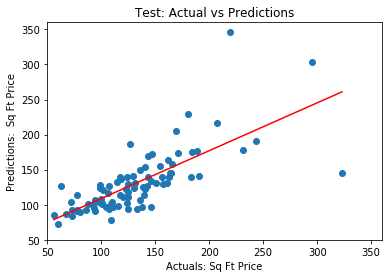

In [121]:
# Plot actual vs predictions for test data
plt.scatter(np.exp(y_test), np.exp(lrpca.predict(Z_test)))
plt.plot(np.unique(np.exp(y_test)), 
        np.poly1d(np.polyfit(np.exp(y_test),  np.exp(lrpca.predict(Z_test)), 1))(np.unique(np.exp(y_test))), c = 'r')
plt.xlim(50,360)
plt.ylim(50,360)
plt.title('Test: Actual vs Predictions')
plt.xlabel('Actuals: Sq Ft Price')
plt.ylabel('Predictions:  Sq Ft Price')
plt.savefig('Images/Test: Actual vs Predictions');

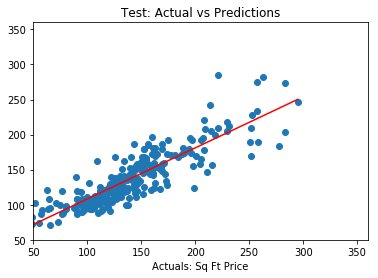

In [125]:
# Plot actual vs predictions for training data

plt.scatter(np.exp(y_train), np.exp(lrpca.predict(Z_train)))
plt.plot(np.unique(np.exp(y_train)), 
        np.poly1d(np.polyfit(np.exp(y_train),  np.exp(lrpca.predict(Z_train)), 1))(np.unique(np.exp(y_train))), c = 'r')
plt.xlim(50,360)
plt.ylim(50,360)
plt.title('Test: Actual vs Predictions')
plt.xlabel('Actuals: Sq Ft Price')
plt.savefig('Images/Test: Actual vs Predictions');


The residuals are normally distributes

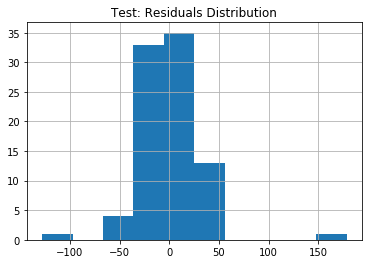

In [126]:
# Plot the residuals distribiution for test data

residuals = np.exp(y_test)- np.exp(lrpca.predict(Z_test))
residuals.hist()
plt.title('Test: Residuals Distribution')
plt.savefig('Images/Test: Residuals Distribution');

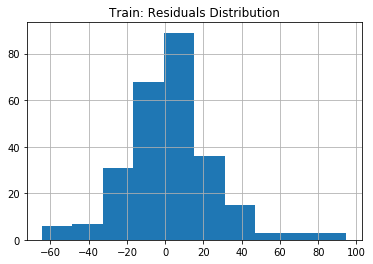

In [122]:
# Plot the residuals distribiution for training data

residuals = np.exp(y_train)- np.exp(lrpca.predict(Z_train))
residuals.hist()
plt.title('Train: Residuals Distribution')
plt.savefig('Images/Train: Residuals Distribution');